In [8]:
import os
from fs_solver import *
#from FsSolver import *

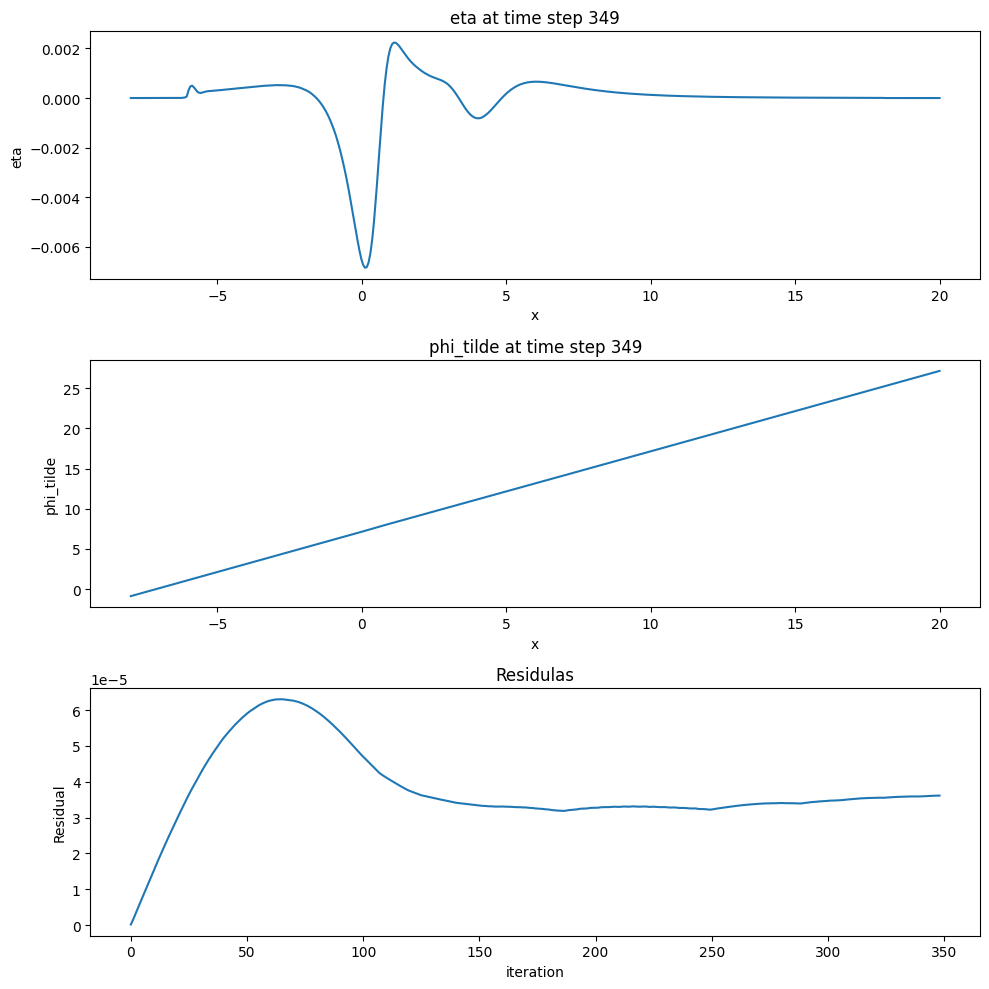

In [37]:
from fs_solver import *
eta = np.loadtxt("./results/eta.txt")
phi = np.loadtxt("./results/phiTilde.txt")
fs_xs = np.loadtxt("./results/fs_xs.txt")
residuals = np.loadtxt("./results/residuals.txt")
residuals, time_step = residuals[:,0], residuals[:,1]

fig, ax = plt.subplots(3, 1, figsize = (10,10))

time = np.where(time_step == 0)[0][0] - 1
ax[0].plot(fs_xs[time], eta[time] - 1)
ax[0].set_title(f"eta at time step {time}" )
ax[0].set_xlabel("x")
ax[0].set_ylabel("eta")

ax[1].plot(fs_xs[time], phi[time])
ax[1].set_title(f"phi_tilde at time step {time}" )
ax[1].set_xlabel("x")
ax[1].set_ylabel("phi_tilde")

ax[2].plot(residuals[:time])
ax[2].set_title("Residulas")
ax[2].set_xlabel("iteration")
ax[2].set_ylabel("Residual")

plt.tight_layout()
plt.show()

In [16]:
time_step

array([0.005, 0.01 , 0.015, ..., 0.   , 0.   , 0.   ], shape=(1500,))

In [9]:
########### Trick: Kør først gang med max_iter_fs = 0, næste gang kører hurtigere ###########

kwargs = {"ylim":[-4,1], "xlim":[-10,23], "V_inf": 10, "g_div": 70, "write":True,
           "n_airfoil": 500,
           "n_fs": 300,
           "n_bed": 75,
           "n_inlet": 15,
           "n_outlet": 15,
           "rtol": 1e-8,
           "fs_rtol": 1e-3,
           "max_iter_fs": 30,
           "max_iter": 30,
           "dt": 4e-3,
           "a":1, "b":1,
           "dot_tol": 1e-4,
           "damp": 200}
FS = FsSolver("0012", alpha = 10, P=2, kwargs = kwargs)
#PFS = PotentialFlowSolver("0012", alpha = 10, P=4, kwargs=kwargs)


dof: 43197


In [ ]:
FS.solve()
#PFS.solve()

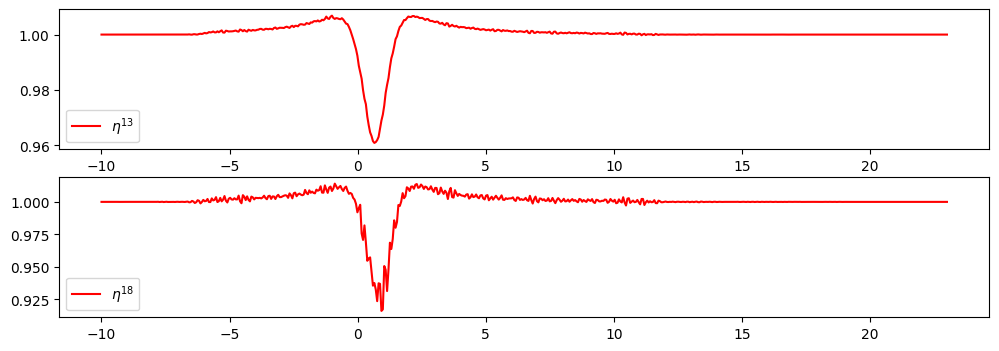

In [29]:
fs_xs = np.copy(FS.fs_xs)
eta = np.copy(FS.etas[18])
eta = eta[np.argsort(FS.fs_xs)]
phi = FS.PhiTilde[np.argsort(FS.fs_xs)]
fs_xs.sort()

fig, ax = plt.subplots(2,1,figsize=(12,4))
ax[0].plot(FS.fs_xs, FS.etas[13], 'r-', label = "$\eta^{13}$")
ax[1].plot(fs_xs, eta, 'r-', label='$\eta^{18}$')
ax[0].legend()
ax[1].legend()

In [ ]:
plt.plot(FS.fs_points[:,0], FS.etas[9])

In [ ]:
model = FS.model
# Mesh and function spaces
number_of_points = FS.fs_points.shape[0]
fs_mesh = fd.IntervalMesh(number_of_points-1, FS.xlim[0], FS.xlim[1])
V_eta = fd.FunctionSpace(fs_mesh, "CG", 1)
V_phi = fd.FunctionSpace(fs_mesh, "CG", 1)

# Defining unknown functions
W = V_eta * V_phi
eta_phi = fd.Function(W)
eta, phi = fd.split(eta_phi)
psi, zeta = fd.TestFunctions(W)

# Defining known functions
phi_n = fd.Function(V_phi)
eta_n = fd.Function(V_eta)
w_n = fd.Function(V_phi)
velocity = np.array(model.velocity.at(FS.fs_points))

phi_n.dat.data[:] = FS.PhiTilde
eta_n.dat.data[:] = FS.fs_points[:, 1]
w_n.dat.data[:] = velocity[:, 1]

g = fd.Constant(9.81)
dt = fd.Constant(0.01)

grad_eta = fd.grad(eta)
grad_phi = fd.grad(phi) + w_n * fd.grad(eta)

F1 = (fd.inner((eta - eta_n)/dt, psi) * fd.dx +
      fd.inner(fd.dot(grad_eta, grad_phi), psi) * fd.dx -
      fd.inner(w_n * (1 + fd.dot(grad_eta, grad_eta)), psi) * fd.dx
      )

F2 = (fd.inner((phi - phi_n)/dt, zeta) * fd.dx +
      fd.inner(g*eta, zeta)* fd.dx +
      fd.Constant(0.5) * 
      fd.inner(fd.dot(grad_phi, grad_phi) - 
               w_n**2 * (fd.Constant(1) + fd.dot(grad_eta, grad_eta)), zeta) * fd.dx
      )

F = F1 + F2

solver_params = {"newton_solver": {"relative_tolerance": 1e-6,}}
fd.solve(F == 0, eta_phi, solver_parameters=solver_params)

eta_n.assign(eta_phi.sub(0))
phi_n.assign(eta_phi.sub(1))

In [ ]:
plt.plot(FS.fs_points[:, 0], eta_phi.sub(0).dat.data[:], 'r-', label='eta_n')
plt.plot(FS.fs_points[:, 0], eta_n.dat.data[:], 'b-.', label='eta_n')